# Image Preprocessing Pipeline Visualisation of Steps

10-06-2024

We collected a dataset of images using red blood cells from sickle cell patients. In this notebook, I will visualize the image preprocessing steps. The goal is to obtain centred images with individual cells rotated to ensure that their longer dimensions are aligned in the same orientation. The resulting steps are implemented in scripts/tif_png_converter.py.

In [4]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def image_rotate_crop(src, cnt, size):
    if len(src.shape) != 2:
        raise ValueError(
            "image_rotate_crop(): Source image should be in grayscale,",
            "and have two dimensions.",
        )
    image_width, image_height = src.shape  # cv2 takes rows and cols swapped
    M = cv2.moments(cnt)

    cx = int(M["m10"] / M["m00"])  # Calculate x,y coordinate of center
    cy = int(M["m01"] / M["m00"])

    # Get box around the contour
    (_, (rect_width, rect_height), angle) = cv2.minAreaRect(cnt)
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1)
    img_rot = cv2.warpAffine(
        src, M, (image_width, image_height), flags=cv2.INTER_LINEAR
    )

    # Calculate the top-left and bottom-right coordinates
    half_size = size // 2
    x1, y1 = max(0, cx - half_size), max(0, cy - half_size)
    x2, y2 = min(image_width, cx + half_size), min(image_height, cy + half_size)
    result = img_rot[y1:y2, x1:x2]

    # Make long side up
    if rect_height < rect_width:
        return cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)
    else:
        return result


def check_border_pixels(src):
    rows, cols = src.shape
    border_coordinates = []

    top_row = [(0, col) for col in range(cols)]
    bottom_row = [(rows - 1, col) for col in range(cols)]
    # Left and right columns exclude corners
    left_col = [(row, 0) for row in range(1, rows - 1)]
    right_col = [(row, cols - 1) for row in range(1, rows - 1)]

    border_coordinates.extend(top_row)
    border_coordinates.extend(bottom_row)
    border_coordinates.extend(left_col)
    border_coordinates.extend(right_col)

    threshold = 150
    saturated_pixels_count = 0

    for pixel in border_coordinates:
        if src[pixel[0]][pixel[1]] < threshold:
            saturated_pixels_count += 1

    if saturated_pixels_count >= 5:
        return True
    else:
        return False

dtype: uint8, shape: (122, 120, 3), min: 0, max: 255


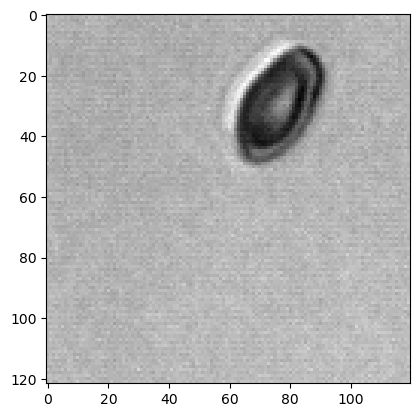

In [6]:
path = (
    "/home/t.afanasyeva/deep_learning_anaemias/resources/images_subset/large_cell.tif"
)
# img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
img = cv2.imread(path)
assert img is not None, "file could not be read, check with os.path.exists()"

print(f"dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}")
plt.imshow(img, "gray", vmin=0, vmax=255)

Expand the borders to ake sure there is no dark corners after rotation.

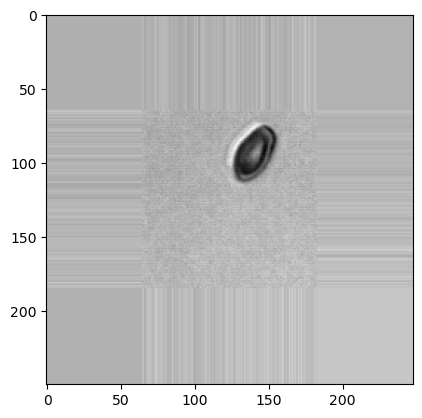

In [ ]:
ext_border = cv2.copyMakeBorder(
    img,
    top=64,
    bottom=64,
    left=64,
    right=64,
    borderType=cv2.BORDER_REPLICATE,
)

plt.imshow(ext_border, "gray")

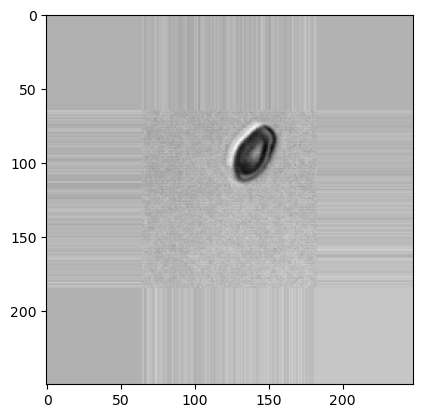

In [32]:
# Change to grayscale
gray = cv2.cvtColor(ext_border, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="grey")

The next steps are being done to obtain a correct contour of the image. 
The original image is kept intact.

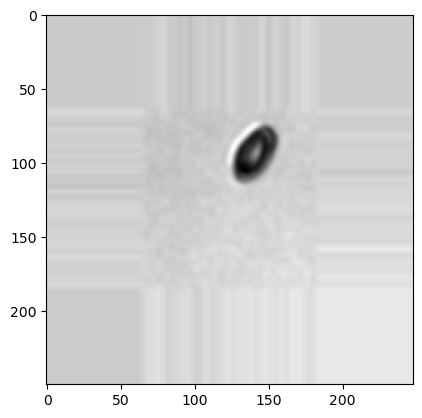

In [9]:
# Smooth image
blur = cv2.GaussianBlur(gray, (5, 5), 3)
plt.imshow(blur, cmap="grey")

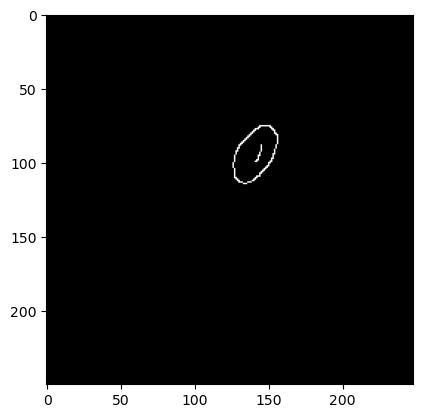

In [10]:
# Detect edges with Canny worked poorly in Imagestream data
edges = cv2.Canny(blur, threshold1=150, threshold2=200)
plt.imshow(edges, cmap="gray")

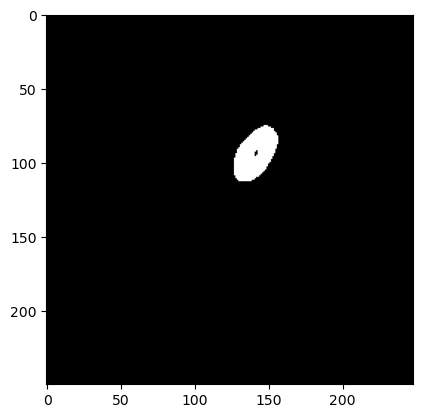

In [11]:
# Thresholding
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.imshow(thresh, cmap="gray")

Close the hole so that we do not detect it as a separate cell.

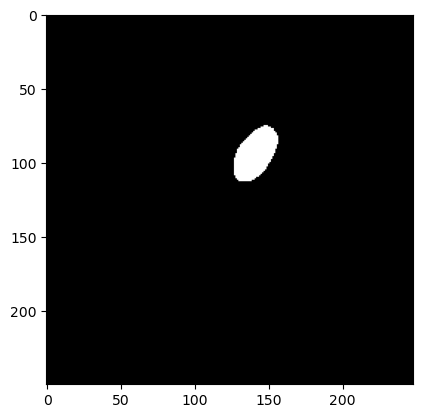

In [12]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

plt.imshow(closed, cmap="gray")

In [13]:
contours, hierarchy = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

valid_contours = []

for contour, h in zip(contours, hierarchy[0]):
    # Check if the contour is not inside another (parent index is -1)
    if h[3] == -1:
        area = cv2.contourArea(contour)
        print(area)
        if 150 <= area <= 900:
            valid_contours.append(contour)


if len(valid_contours) != 1:
    print("Excluding due to diplication or an absense of a contour")

722.5


In [14]:
len(valid_contours)

1

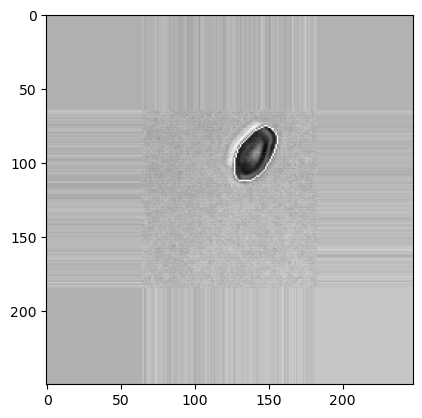

In [15]:
cnt = valid_contours[0]
cv2.drawContours(gray, cnt, -1, (255, 0, 0), 1)
plt.imshow(gray, cmap="grey")

Calculate the centre to be able to rotate around it

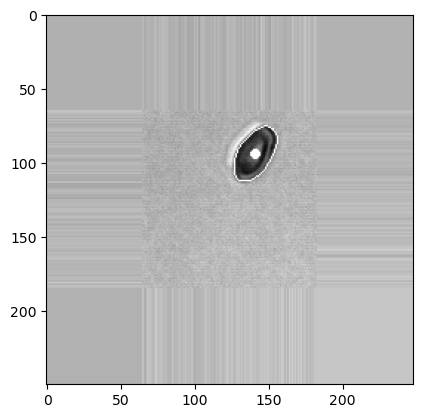

In [16]:
circle_img = gray.copy()
src = gray

image_width, image_height = src.shape  # cv2 takes rows and cols swapped
M = cv2.moments(cnt)

cx = int(M["m10"] / M["m00"])  # Calculate x,y coordinate of center
cy = int(M["m01"] / M["m00"])


cv2.circle(circle_img, (cx, cy), 2, (255, 0, 0), 2)
plt.imshow(circle_img, cmap="grey")

Draw a box around the centre

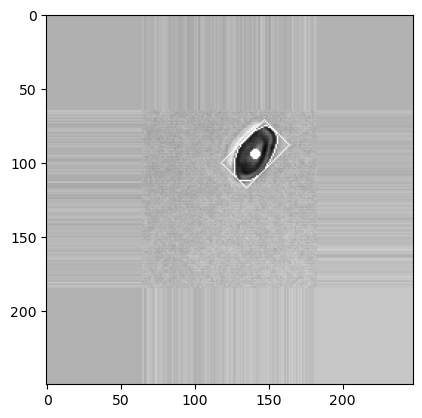

In [17]:
box_img = circle_img.copy()

# Get box around the contour
(_, (rect_width, rect_height), angle) = cv2.minAreaRect(cnt)
box = cv2.boxPoints(cv2.minAreaRect(cnt))  # cv2.cv.BoxPoints(rect) for OpenCV <3.x
box = np.intp(box)
cv2.drawContours(box_img, [box], 0, (255, 0, 0), 1)

plt.imshow(box_img, cmap="grey")

Rotate the image

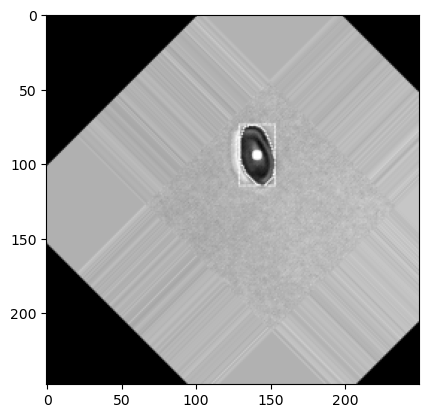

In [18]:
M = cv2.getRotationMatrix2D((cx, cy), angle, 1)
img_rot = cv2.warpAffine(
    box_img, M, (image_width, image_height), flags=cv2.INTER_LINEAR
)

plt.imshow(img_rot, cmap="grey")

Resize to 64x64

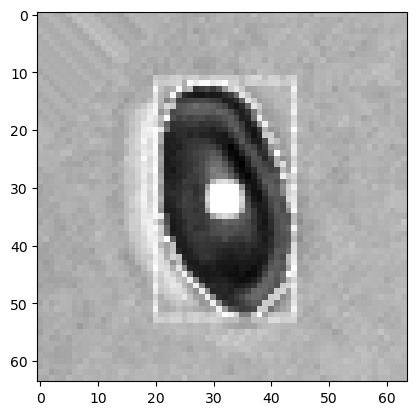

In [19]:
size = 64
# Calculate the top-left and bottom-right coordinates
half_size = size // 2
x1, y1 = max(0, cx - half_size), max(0, cy - half_size)
x2, y2 = min(image_width, cx + half_size), min(image_height, cy + half_size)
result = img_rot[y1:y2, x1:x2]

plt.imshow(result, cmap="grey")

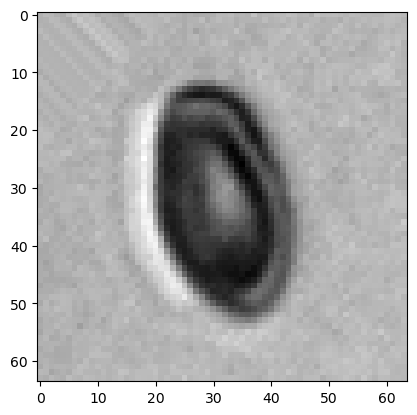

In [ ]:
# Cropping out 64x64

new_image_size = 64
rotated_cropped = image_rotate_crop(gray, valid_contours[0], new_image_size)

plt.imshow(rotated_cropped, cmap="grey")

Plotting the images together

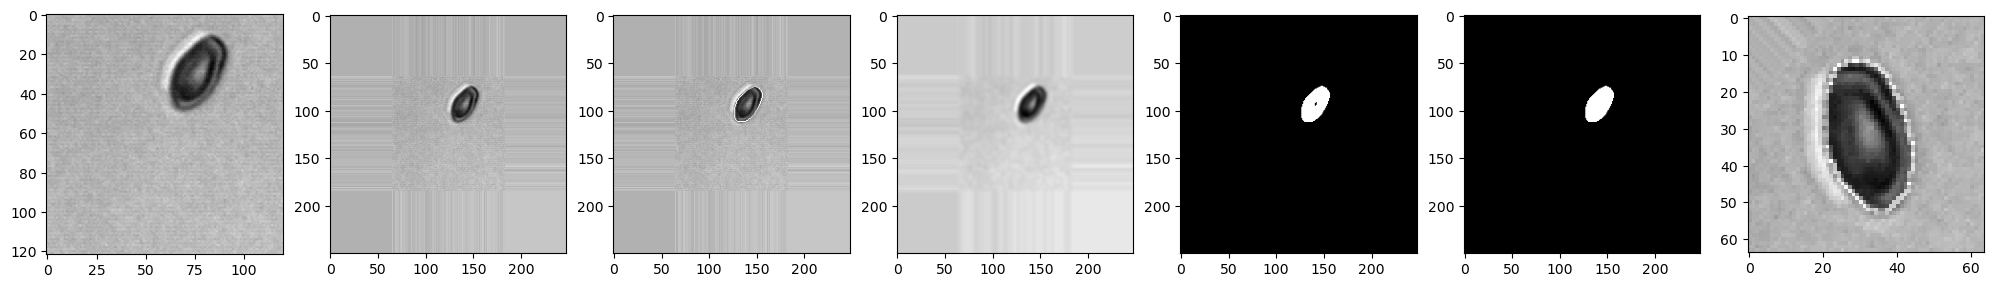

In [ ]:
plt.figure(figsize=(25, 25))

plt.subplot(1, 7, 1)
plt.imshow(img, "gray", vmin=0, vmax=255)

plt.subplot(1, 7, 2)
plt.imshow(ext_border, "gray")

plt.subplot(1, 7, 3)
plt.imshow(gray, cmap="grey")

plt.subplot(1, 7, 4)
plt.imshow(blur, cmap="grey")

plt.subplot(1, 7, 5)
plt.imshow(thresh, cmap="gray")

plt.subplot(1, 7, 6)
plt.imshow(closed, cmap="gray")

plt.subplot(1, 7, 7)
plt.imshow(rotated_cropped, cmap="grey")

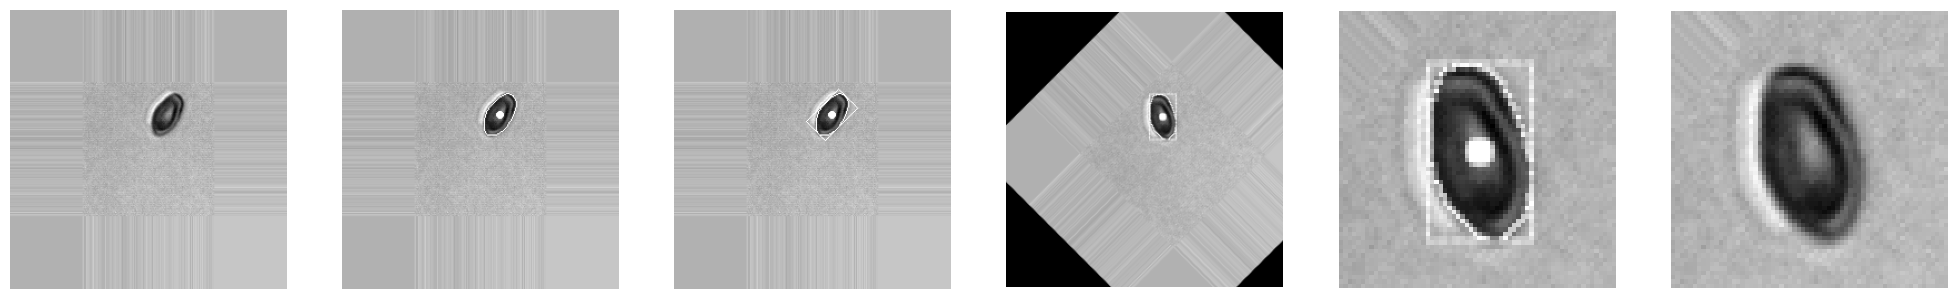

In [ ]:
plt.figure(figsize=(25, 25))
size = (1, 6)

my_images = [gray, circle_img, box_img, img_rot, result, rotated_cropped]

for i in range(1, size[1] + 1):
    plt.subplot(*size, i)

for my_image in my_images:
    plt.imshow(my_image, cmap="grey")

for i, my_image in enumerate(my_images):
    plt.subplot(size[0], size[1], i + 1)
    plt.imshow(my_image, cmap="gray")
    plt.axis("off")